This experiments are for testing how many ground states are returned for problems with the same structure (i.e same number of qubits and connectivity requirements). We generate problems with the same structure but with different percetange of ground states compared to the overall search space. We then compare their performance with various SAT solvers available at https://github.com/pysathq/pysat.

In [1]:
import sys
sys.path.append("../")
from utils import load_cnf, cnf_to_bqm
from embedding_utils import *
import seaborn as sns
from redundancy import *
from utils import *
from dwave.embedding.chain_strength import scaled
import pandas as pd
from brute_force import get_bqm_random_sat
import numpy as np
import matplotlib.pyplot as plt
from statistics import variance
from greedy import SteepestDescentSolver

In [2]:
one_answer = 9223372036854775807
thresholds = [1, 4611686018427387903, 9223372036854775807, 13835058055282163711, 18446744073709551615]
qpu = get_qpu()
quimera_qpu = DWaveSampler(solver={"name": "DW_2000Q_6"})
solver_greedy = SteepestDescentSolver()

In [26]:
def get_vertices_degrees(bqm):
    answer = []
    for (node, neighbours) in bqm.adj.items():
        answer.append(len(neighbours)) 
    return answer

def get_file_bqm(file_name):
    bqm, estimated_num_variables = unicorn_file_parser(f"./sat_ratio/{file_name}.unicorn")
    vertices_degrees = get_vertices_degrees(bqm)
    avg_degrees = round(float(sum(vertices_degrees))/float(len(vertices_degrees)),2)
    variance_degrees = round(variance(vertices_degrees),2)
    
    num_variables, num_clauses, variables, clauses = load_cnf(f"./sat_ratio/{file_name}.cnf")
    print(f"file: {file_name}")
    print(f"cnf vars, clauses, clauses_to_var = {num_variables}, {num_clauses}, {round(num_clauses/num_variables,2)}")
    print(f"qubo vars {len(bqm.variables)}")
    print(f"conn avg, variance, max = {avg_degrees}, {variance_degrees}, {max(vertices_degrees)}")
    
    return bqm

In [27]:
bqm = get_file_bqm("1")

file: 1
cnf vars, clauses, clauses_to_var = 128, 192, 1.5
qubo vars 127
conn avg, variance, max = 2.96, 1.02, 4


In [28]:
max([abs(x) for x in bqm.linear.values()])

6.0

In [29]:
max([abs(x) for x in bqm.quadratic.values()])

4.0

In [4]:
def get_input_value(sample, one_input):
    answer = 0
    for (index,element) in enumerate(one_input):
        answer+= (sample[element])*(2**index)
    return int(answer)

def get_input_values(sample, input_ids):
    answer = []
    
    for i in input_ids:
        answer.append(get_input_value(sample, i))
    return ','.join([str(x) for x in answer]) 

In [5]:
def get_results_dataframe(file, input_ids, reads=100, bottom=0.25, top=5, is_pegasus=True, is_chimera=True, is_local_search=True, random_seed_chimera=None):
    bqm = get_file_bqm(file)
    
    
    
    chain_strengths = []
    energies = []
    input_vals = []
    file_name = []
    sampleset_types = []
    qpus = []
    if is_pegasus:
        embedding_1, random_seed = find_best_embedding(bqm, qpu)
        sampler = FixedEmbeddingComposite(qpu, embedding_1)
        for chain_strength in list(np.arange(bottom, top + 0.25, 0.25)):
            
            sampleset = sampler.sample(bqm, num_reads=reads, chain_strength=chain_strength, auto_scale=True, answer_mode='raw')
            assert(len(sampleset) == reads)
            print("advantage:",chain_strength, "raw", sampleset.first.energy)
            for sample in sampleset:
                file_name.append(file)
                chain_strengths.append(chain_strength)
                energies.append(bqm.energy(sample))
                sampleset_types.append("raw")
                qpus.append("Advantage4.1")
                input_vals.append(get_input_values(sample, input_ids))

            if is_local_search:
                sampleset_pp = solver_greedy.sample(bqm, initial_states=sampleset)
                print(chain_strength, "pp_local_search", sampleset.first.energy)
                for sample in sampleset:
                    file_name.append(file)
                    chain_strengths.append(chain_strength)
                    energies.append(bqm.energy(sample))
                    input_vals.append(get_input_values(sample, input_ids))
                    qpus.append("Advantage4.1")
                    sampleset_types.append("pp_local_search")
                print("************")
    if is_chimera:
        if random_seed_chimera is None:
            embedding_2, random_seed = find_best_embedding(bqm, quimera_qpu)
        else:
            embedding_2 = get_embedding(bqm, quimera_qpu, random_seed=random_seed_chimera)
        sampler = FixedEmbeddingComposite(quimera_qpu, embedding_2)
        for chain_strength in list(np.arange(bottom, top + 0.25, 0.25)):
            print("reads:",reads)
            sampleset = sampler.sample(bqm, num_reads=reads, chain_strength=chain_strength, auto_scale=True, answer_mode='raw')
            assert(len(sampleset) == reads)
            print('chimera:',chain_strength, "raw", sampleset.first.energy)
            for sample in sampleset:
                file_name.append(file)
                chain_strengths.append(chain_strength)
                energies.append(bqm.energy(sample))
                sampleset_types.append("raw")
                qpus.append("DW_2000Q_6")
                input_vals.append(get_input_values(sample, input_ids))
            if is_local_search:
                sampleset_pp = solver_greedy.sample(bqm, initial_states=sampleset)
                print(chain_strength, "pp_local_search", sampleset.first.energy)
                for sample in sampleset_pp:
                    file_name.append(file)
                    chain_strengths.append(chain_strength)
                    energies.append(bqm.energy(sample))
                    input_vals.append(get_input_values(sample, input_ids))
                    qpus.append("DW_2000Q_6")
                    sampleset_types.append("pp_local_search")
                print("************")
        
    return pd.DataFrame({
        'file': file_name,
        'type': sampleset_types,
        'chain_strength': chain_strengths,
        'energy': energies,
        'input_values': input_vals,
        'qpu': qpus
    })

In [6]:
def get_0_energy_counts_df(names, bottom=0.25, top=5):
    file_names = []
    chain_strengths = []
    counts = []
    for name in names:
        df = pd.read_csv(f'sat_ratio/outputs/{name}.csv')
        df = df.drop(['Unnamed: 0'], axis=1)
        df = df[df.type == 'raw']
        df = df[df.qpu == 'DW_2000Q_6']
        for chain_strength in list(np.arange(bottom, top + 0.25, 0.25)):
            file_names.append(name)
            chain_strengths.append(chain_strength)
            counts.append(df[(df.energy ==0) & (df.chain_strength == chain_strength)].shape[0])
    df_energy_0_counts = pd.DataFrame({
        'file': file_names,
        'chain_strength': chain_strengths,
        'zero_energy_count': counts
    })
    return df_energy_0_counts
    
def merge_outputs(filenames):
    df_all = pd.DataFrame()
    for name in filenames:
        df = pd.read_csv(f'sat_ratio/outputs/{name}.csv')
        df = df.drop(['Unnamed: 0'], axis=1)
        df = df[df.type == 'raw']
        df = df[df.qpu == 'DW_2000Q_6']
        df_all = df_all.append(df)
    return df_all

# Just one answer (EASY)

In [23]:
# input_ids = [[2,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51,53,55,57,59,61,63,65,67,69,71,73,75,77,79,81,83,85,87,89,91,93,95,97,99,101,103,105,107,109,111,113,115,117,119,121,123,125,127]]
# file = "1"
# df = get_results_dataframe(file, input_ids)
# df.to_csv('sat_ratio/outputs/1.csv' )
# df

<AxesSubplot:xlabel='chain_strength', ylabel='energy'>

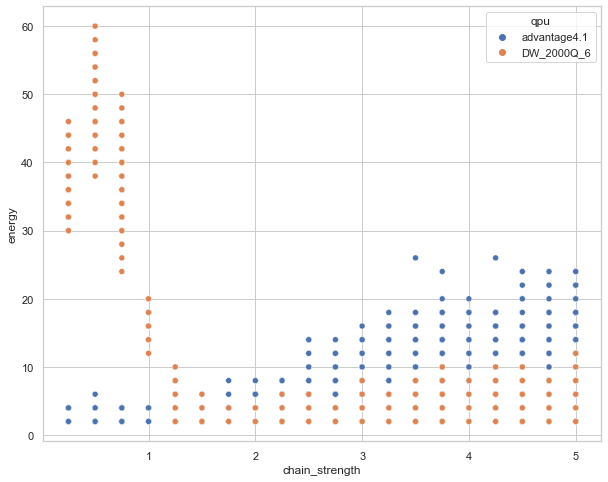

In [24]:
df = pd.read_csv('sat_ratio/outputs/1.csv')
sns.set(rc={'figure.figsize':(10,8)})
sns.set_style("whitegrid", {'axes.grid' : True})
sns.scatterplot(data=df[df.type=='raw'], x="chain_strength", y="energy", hue="qpu")

# Just one answer

In [40]:
# input_ids = [[65,64,63,62,61,60,59,58,57,56,55,54,53,52,51,50,49,48,47,46,45,44,43,42,41,40,39,38,37,36,35,34,33,32,31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2]]
# file = "p1"
# df = get_results_dataframe(file, input_ids)
# df.to_csv('sat_ratio/outputs/p1.csv' )
# df


<AxesSubplot:xlabel='chain_strength', ylabel='energy'>

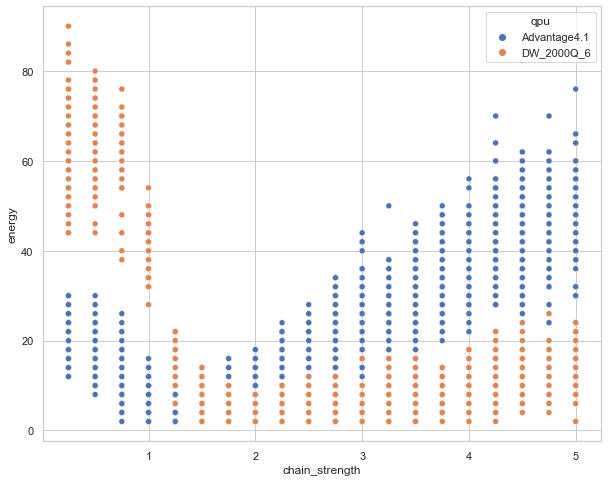

In [25]:
df = pd.read_csv('sat_ratio/outputs/p1.csv')
sns.set(rc={'figure.figsize':(10,8)})
sns.set_style("whitegrid", {'axes.grid' : True})
sns.scatterplot(data=df[df.type=='raw'], x="chain_strength", y="energy", hue="qpu")

# 25% are answers

In [68]:
input_ids = [[65,64,63,62,61,60,59,58,57,56,55,54,53,52,51,50,49,48,47,46,45,44,43,42,41,40,39,38,37,36,35,34,33,32,31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2]]
file = "p25"
df = get_results_dataframe(file, input_ids, is_pegasus=False,is_local_search=False)
df.to_csv('sat_ratio/outputs/p25.csv' )
df

file: p25
cnf vars, clauses, clauses_to_var = 191, 444, 2.32
qubo vars 253
conn avg, variance, max = 3.49, 2.23, 6
best embedding random_seed 2
best embedding max_chain_length 4
best embedding qubits used 396
best embedding variance: 0.6435472739820566
chimera: 0.25 raw 72.0
chimera: 0.5 raw 64.0
chimera: 0.75 raw 50.0
chimera: 1.0 raw 18.0
chimera: 1.25 raw 2.0
chimera: 1.5 raw 0.0
chimera: 1.75 raw 0.0
chimera: 2.0 raw 0.0
chimera: 2.25 raw 0.0
chimera: 2.5 raw 0.0
chimera: 2.75 raw 0.0
chimera: 3.0 raw 0.0
chimera: 3.25 raw 0.0
chimera: 3.5 raw 0.0
chimera: 3.75 raw 0.0
chimera: 4.0 raw 2.0
chimera: 4.25 raw 2.0
chimera: 4.5 raw 2.0
chimera: 4.75 raw 2.0
chimera: 5.0 raw 2.0


,file,type,chain_strength,energy,input_values,qpu
0,p25,raw,0.25,72.0,4602678818098905088,DW_2000Q_6
1,p25,raw,0.25,74.0,4602678818098905088,DW_2000Q_6
2,p25,raw,0.25,76.0,4602678818098905088,DW_2000Q_6
3,p25,raw,0.25,76.0,4611686017353644544,DW_2000Q_6
4,p25,raw,0.25,76.0,4602678818098905088,DW_2000Q_6
...,...,...,...,...,...,...
1995,p25,raw,5.00,22.0,3438757717694847488,DW_2000Q_6
1996,p25,raw,5.00,22.0,2318819304016779776,DW_2000Q_6
1997,p25,raw,5.00,22.0,7479159339988883456,DW_2000Q_6
1998,p25,raw,5.00,22.0,18261207921376350208,DW_2000Q_6


<AxesSubplot:xlabel='chain_strength', ylabel='energy'>

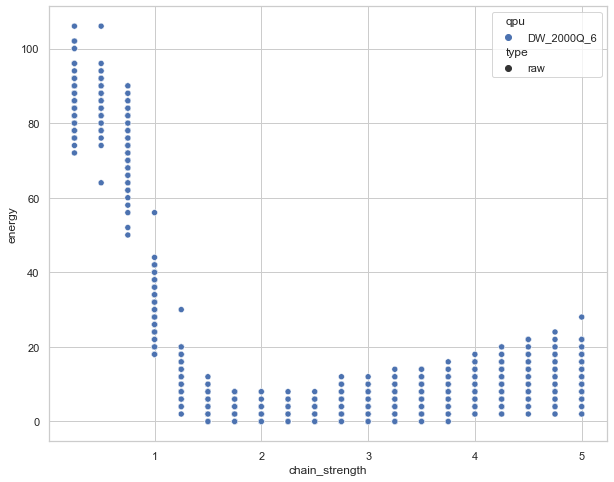

In [98]:
df = pd.read_csv('sat_ratio/outputs/p25.csv')
sns.set(rc={'figure.figsize':(10,8)})
sns.set_style("whitegrid", {'axes.grid' : True})
sns.scatterplot(data=df, x="chain_strength", y="energy", hue="qpu", style="type")

# 50% are answers

In [70]:
input_ids = [[65,64,63,62,61,60,59,58,57,56,55,54,53,52,51,50,49,48,47,46,45,44,43,42,41,40,39,38,37,36,35,34,33,32,31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2]]
file = "p50"
df = get_results_dataframe(file, input_ids)
df.to_csv('sat_ratio/outputs/p50.csv' )
df

file: p50
cnf vars, clauses, clauses_to_var = 191, 444, 2.32
qubo vars 253
conn avg, variance, max = 3.49, 2.23, 6
best embedding random_seed 80
best embedding max_chain_length 2
best embedding qubits used 264
best embedding variance: 0.04175293305728089
advantage: 0.25 raw 12.0
0.25 pp_local_search 12.0
************
advantage: 0.5 raw 8.0
0.5 pp_local_search 8.0
************
advantage: 0.75 raw 0.0
0.75 pp_local_search 0.0
************
advantage: 1.0 raw 0.0
1.0 pp_local_search 0.0
************
advantage: 1.25 raw 0.0
1.25 pp_local_search 0.0
************
advantage: 1.5 raw 0.0
1.5 pp_local_search 0.0
************
advantage: 1.75 raw 0.0
1.75 pp_local_search 0.0
************
advantage: 2.0 raw 2.0
2.0 pp_local_search 2.0
************
advantage: 2.25 raw 0.0
2.25 pp_local_search 0.0
************
advantage: 2.5 raw 2.0
2.5 pp_local_search 2.0
************
advantage: 2.75 raw 4.0
2.75 pp_local_search 4.0
************
advantage: 3.0 raw 8.0
3.0 pp_local_search 8.0
************
advantage: 

,file,type,chain_strength,energy,input_values,qpu
0,p50,raw,0.25,12.0,1694091158569873152,Advantage4.1
1,p50,raw,0.25,14.0,566817376619498880,Advantage4.1
2,p50,raw,0.25,16.0,5156044602526919680,Advantage4.1
3,p50,raw,0.25,16.0,1387108647757903104,Advantage4.1
4,p50,raw,0.25,16.0,4309618145255220736,Advantage4.1
...,...,...,...,...,...,...
7995,p50,pp_local_search,5.00,12.0,1668408830671298560,DW_2000Q_6
7996,p50,pp_local_search,5.00,12.0,2041217907180103424,DW_2000Q_6
7997,p50,pp_local_search,5.00,14.0,5389507395426116608,DW_2000Q_6
7998,p50,pp_local_search,5.00,14.0,8625933527393030144,DW_2000Q_6


<AxesSubplot:xlabel='chain_strength', ylabel='energy'>

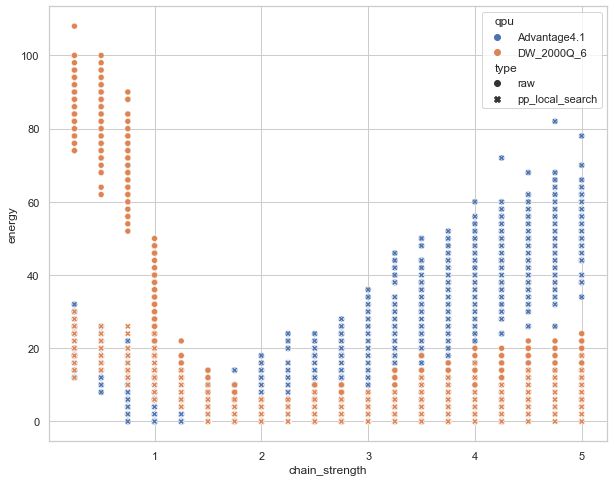

In [99]:
df = pd.read_csv('sat_ratio/outputs/p50.csv')
sns.set(rc={'figure.figsize':(10,8)})
sns.set_style("whitegrid", {'axes.grid' : True})
sns.scatterplot(data=df, x="chain_strength", y="energy", hue="qpu", style="type")

# 75% are answers

In [73]:
input_ids = [[65,64,63,62,61,60,59,58,57,56,55,54,53,52,51,50,49,48,47,46,45,44,43,42,41,40,39,38,37,36,35,34,33,32,31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2]]
file = "p75"
df = get_results_dataframe(file, input_ids,is_pegasus=False)
df.to_csv('sat_ratio/outputs/p75.csv' )
df

file: p75
cnf vars, clauses, clauses_to_var = 191, 444, 2.32
qubo vars 253
conn avg, variance, max = 3.49, 2.23, 6
best embedding random_seed 2
best embedding max_chain_length 4
best embedding qubits used 396
best embedding variance: 0.6435472739820566
chimera: 0.25 raw 70.0
0.25 pp_local_search 70.0
************
chimera: 0.5 raw 72.0
0.5 pp_local_search 72.0
************
chimera: 0.75 raw 58.0
0.75 pp_local_search 58.0
************
chimera: 1.0 raw 14.0
1.0 pp_local_search 14.0
************
chimera: 1.25 raw 4.0
1.25 pp_local_search 4.0
************
chimera: 1.5 raw 0.0
1.5 pp_local_search 0.0
************
chimera: 1.75 raw 0.0
1.75 pp_local_search 0.0
************
chimera: 2.0 raw 0.0
2.0 pp_local_search 0.0
************
chimera: 2.25 raw 0.0
2.25 pp_local_search 0.0
************
chimera: 2.5 raw 0.0
2.5 pp_local_search 0.0
************
chimera: 2.75 raw 0.0
2.75 pp_local_search 0.0
************
chimera: 3.0 raw 0.0
3.0 pp_local_search 0.0
************
chimera: 3.25 raw 0.0
3.25 pp_l

,file,type,chain_strength,energy,input_values,qpu
0,p75,raw,0.25,70.0,13826050854953680896,DW_2000Q_6
1,p75,raw,0.25,78.0,13826050854953680896,DW_2000Q_6
2,p75,raw,0.25,78.0,13826050854953680896,DW_2000Q_6
3,p75,raw,0.25,78.0,13826050854953680896,DW_2000Q_6
4,p75,raw,0.25,80.0,13826050854953678848,DW_2000Q_6
...,...,...,...,...,...,...
3995,p75,pp_local_search,5.00,12.0,1419999657722461696,DW_2000Q_6
3996,p75,pp_local_search,5.00,14.0,4628994775617888256,DW_2000Q_6
3997,p75,pp_local_search,5.00,16.0,10932544544251289600,DW_2000Q_6
3998,p75,pp_local_search,5.00,18.0,8560134669786676224,DW_2000Q_6


<AxesSubplot:xlabel='chain_strength', ylabel='energy'>

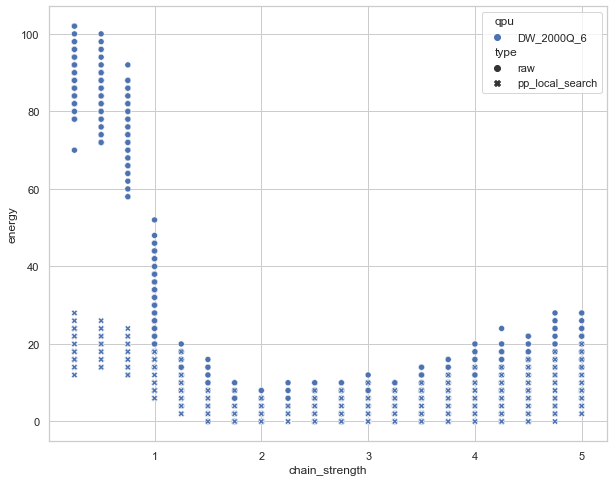

In [100]:
df = pd.read_csv('sat_ratio/outputs/p75.csv')
sns.set(rc={'figure.figsize':(10,8)})
sns.set_style("whitegrid", {'axes.grid' : True})
sns.scatterplot(data=df, x="chain_strength", y="energy", hue="qpu", style="type")

# 99% are answers

In [81]:
input_ids = [[65,64,63,62,61,60,59,58,57,56,55,54,53,52,51,50,49,48,47,46,45,44,43,42,41,40,39,38,37,36,35,34,33,32,31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2]]
file = "p100"
df = get_results_dataframe(file, input_ids, is_pegasus=False)
df.to_csv('sat_ratio/outputs/p100.csv' )
df

file: p100
cnf vars, clauses, clauses_to_var = 191, 444, 2.32
qubo vars 253
conn avg, variance, max = 3.49, 2.23, 6
best embedding random_seed 2
best embedding max_chain_length 4
best embedding qubits used 396
best embedding variance: 0.6435472739820566
reads: 100
chimera: 0.25 raw 76.0
0.25 pp_local_search 76.0
************
reads: 100
chimera: 0.5 raw 62.0
0.5 pp_local_search 62.0
************
reads: 100
chimera: 0.75 raw 48.0
0.75 pp_local_search 48.0
************
reads: 100
chimera: 1.0 raw 14.0
1.0 pp_local_search 14.0
************
reads: 100
chimera: 1.25 raw 0.0
1.25 pp_local_search 0.0
************
reads: 100
chimera: 1.5 raw 0.0
1.5 pp_local_search 0.0
************
reads: 100
chimera: 1.75 raw 0.0
1.75 pp_local_search 0.0
************
reads: 100
chimera: 2.0 raw 0.0
2.0 pp_local_search 0.0
************
reads: 100
chimera: 2.25 raw 0.0
2.25 pp_local_search 0.0
************
reads: 100
chimera: 2.5 raw 0.0
2.5 pp_local_search 0.0
************
reads: 100
chimera: 2.75 raw 0.0
2.75 

,file,type,chain_strength,energy,input_values,qpu
0,p100,raw,0.25,76.0,18435485073567383552,DW_2000Q_6
1,p100,raw,0.25,76.0,18435485073567383552,DW_2000Q_6
2,p100,raw,0.25,76.0,18437736873380542464,DW_2000Q_6
3,p100,raw,0.25,76.0,18437736873381068800,DW_2000Q_6
4,p100,raw,0.25,78.0,18437736873381068800,DW_2000Q_6
...,...,...,...,...,...,...
3995,p100,pp_local_search,5.00,12.0,8641976272837311488,DW_2000Q_6
3996,p100,pp_local_search,5.00,12.0,3425793955956060160,DW_2000Q_6
3997,p100,pp_local_search,5.00,14.0,3159212534658747392,DW_2000Q_6
3998,p100,pp_local_search,5.00,14.0,881464073326346752,DW_2000Q_6


<AxesSubplot:xlabel='chain_strength', ylabel='energy'>

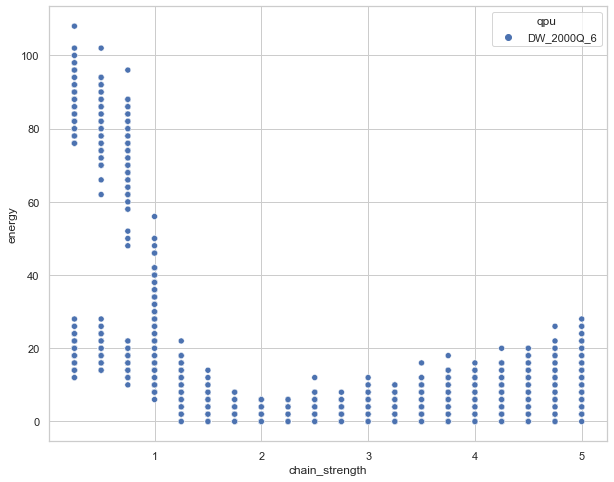

In [101]:
df = pd.read_csv('sat_ratio/outputs/p100.csv')
sns.set(rc={'figure.figsize':(10,8)})
sns.set_style("whitegrid", {'axes.grid' : True})
sns.scatterplot(data=df, x="chain_strength", y="energy", hue="qpu")

# Merging Results

In [109]:
df_all = merge_outputs(['p1', 'p25', 'p50', 'p75', 'p100'])

In [1]:
sns.set(rc={'figure.figsize':(10,8)})
sns.set_style("darkgrid")
sns.lineplot(data=df_all[(df_all.chain_strength>1) & (df_all.chain_strength<3) ], x="chain_strength", y="energy", hue="file")

NameError: name 'sns' is not defined

In [111]:
df_energy_0_counts = get_0_energy_counts_df(['p1', 'p25', 'p50', 'p75', 'p100'])

<AxesSubplot:xlabel='chain_strength', ylabel='zero_energy_count'>

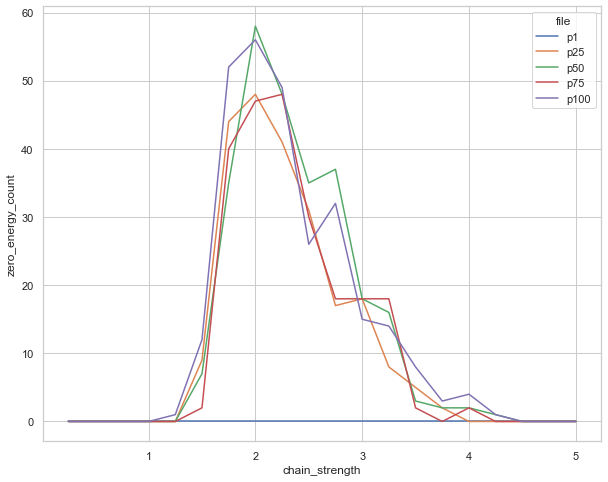

In [113]:
sns.set(rc={'figure.figsize':(10,8)})
sns.set_style("whitegrid", {'axes.grid' : True})
sns.lineplot(data=df_energy_0_counts, x="chain_strength", y="zero_energy_count", hue="file")

<AxesSubplot:xlabel='chain_strength', ylabel='zero_energy_count'>

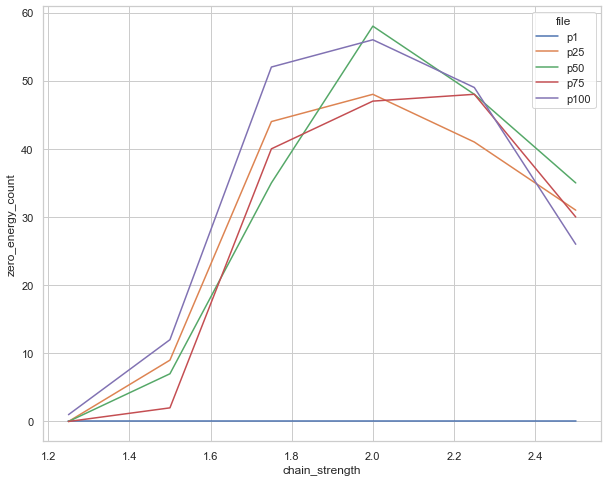

In [114]:
sns.set(rc={'figure.figsize':(10,8)})
sns.set_style("whitegrid", {'axes.grid' : True})
df_temp = df_energy_0_counts[(df_energy_0_counts.chain_strength>1) &( df_energy_0_counts.chain_strength < 2.75)]
sns.lineplot(data=df_temp, x="chain_strength", y="zero_energy_count", hue="file")

# 500 reads

In [ ]:
# next tests over 1.5 -> 2.25 (included)

In [119]:
# input_ids = [[65,64,63,62,61,60,59,58,57,56,55,54,53,52,51,50,49,48,47,46,45,44,43,42,41,40,39,38,37,36,35,34,33,32,31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2]]
# file = "p25"
# df25 = get_results_dataframe(file, input_ids, is_pegasus=False,is_local_search=False,reads=500, bottom=1.5, top=2.25)
# df25.to_csv('sat_ratio/outputs/p25_500.csv' )

# input_ids = [[65,64,63,62,61,60,59,58,57,56,55,54,53,52,51,50,49,48,47,46,45,44,43,42,41,40,39,38,37,36,35,34,33,32,31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2]]
# file = "p50"
# df50 = get_results_dataframe(file, input_ids, is_pegasus=False,is_local_search=False,reads=500, bottom=1.5, top=2.25)
# df50.to_csv('sat_ratio/outputs/p50_500.csv' )

# input_ids = [[65,64,63,62,61,60,59,58,57,56,55,54,53,52,51,50,49,48,47,46,45,44,43,42,41,40,39,38,37,36,35,34,33,32,31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2]]
# file = "p75"
# df75 = get_results_dataframe(file, input_ids, is_pegasus=False,is_local_search=False,reads=500, bottom=1.5, top=2.25)
# df75.to_csv('sat_ratio/outputs/p75_500.csv' )

# input_ids = [[65,64,63,62,61,60,59,58,57,56,55,54,53,52,51,50,49,48,47,46,45,44,43,42,41,40,39,38,37,36,35,34,33,32,31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2]]
# file = "p100"
# df100 = get_results_dataframe(file, input_ids, is_pegasus=False,is_local_search=False,reads=500, bottom=1.5, top=2.25)
# df100.to_csv('sat_ratio/outputs/p100_500.csv' )


In [116]:
df_all = merge_outputs(['p25_500', 'p50_500', 'p75_500', 'p100_500'])

<AxesSubplot:xlabel='chain_strength', ylabel='energy'>

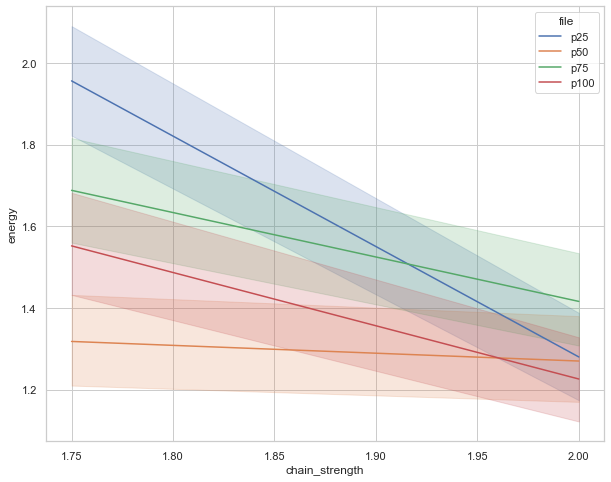

In [131]:
sns.set(rc={'figure.figsize':(10,8)})
sns.set_style("whitegrid", {'axes.grid' : True})
sns.lineplot(data=df_all, x="chain_strength", y="energy", hue="file")

In [126]:
df_energy_0_counts = get_0_energy_counts_df(['p25_500', 'p50_500', 'p75_500', 'p100_500'], bottom=1.5, top=2.25)

<AxesSubplot:xlabel='chain_strength', ylabel='zero_energy_count'>

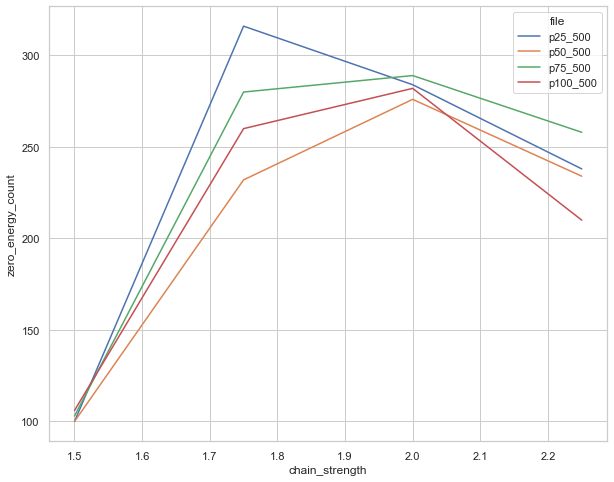

In [128]:
sns.set(rc={'figure.figsize':(10,8)})
sns.set_style("whitegrid", {'axes.grid' : True})
sns.lineplot(data=df_energy_0_counts, x="chain_strength", y="zero_energy_count", hue="file")

# 1k samples

In [129]:
# input_ids = [[65,64,63,62,61,60,59,58,57,56,55,54,53,52,51,50,49,48,47,46,45,44,43,42,41,40,39,38,37,36,35,34,33,32,31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2]]
# file = "p25"
# df25 = get_results_dataframe(file, input_ids, is_pegasus=False,is_local_search=False,reads=1000, bottom=1.75, top=2.0)
# df25.to_csv('sat_ratio/outputs/p25_1000.csv' )

# input_ids = [[65,64,63,62,61,60,59,58,57,56,55,54,53,52,51,50,49,48,47,46,45,44,43,42,41,40,39,38,37,36,35,34,33,32,31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2]]
# file = "p50"
# df50 = get_results_dataframe(file, input_ids, is_pegasus=False,is_local_search=False,reads=1000, bottom=1.75, top=2.0)
# df50.to_csv('sat_ratio/outputs/p50_1000.csv' )

# input_ids = [[65,64,63,62,61,60,59,58,57,56,55,54,53,52,51,50,49,48,47,46,45,44,43,42,41,40,39,38,37,36,35,34,33,32,31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2]]
# file = "p75"
# df75 = get_results_dataframe(file, input_ids, is_pegasus=False,is_local_search=False,reads=1000, bottom=1.75, top=2.0)
# df75.to_csv('sat_ratio/outputs/p75_1000.csv' )

# input_ids = [[65,64,63,62,61,60,59,58,57,56,55,54,53,52,51,50,49,48,47,46,45,44,43,42,41,40,39,38,37,36,35,34,33,32,31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2]]
# file = "p100"
# df100 = get_results_dataframe(file, input_ids, is_pegasus=False,is_local_search=False,reads=1000, bottom=1.75, top=2.0)
# df100.to_csv('sat_ratio/outputs/p100_1000.csv' )


<AxesSubplot:xlabel='chain_strength', ylabel='energy'>

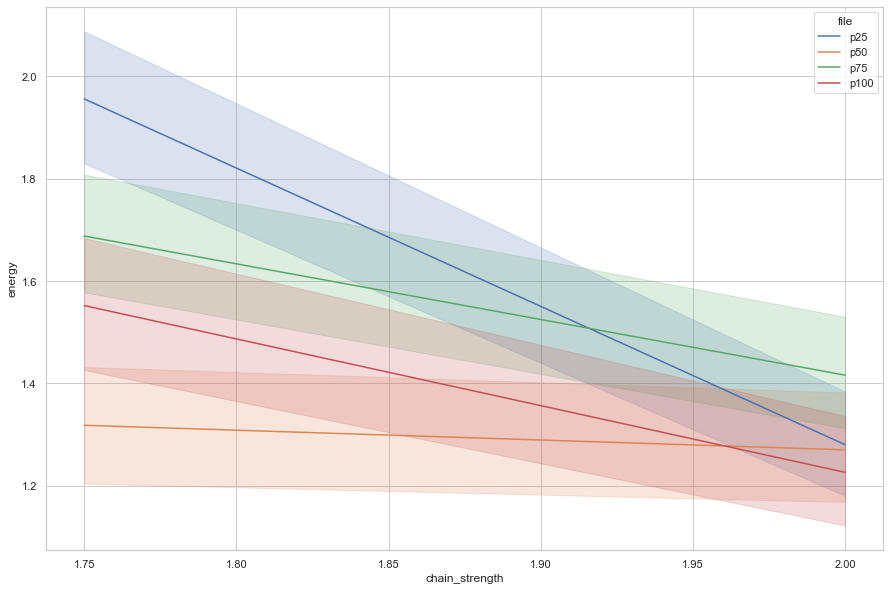

In [132]:
df_all = merge_outputs(['p25_1000', 'p50_1000', 'p75_1000', 'p100_1000'])
sns.set(rc={'figure.figsize':(15,10)})
sns.set_style("whitegrid", {'axes.grid' : True})
sns.lineplot(data=df_all, x="chain_strength", y="energy", hue="file")

<AxesSubplot:xlabel='chain_strength', ylabel='zero_energy_count'>

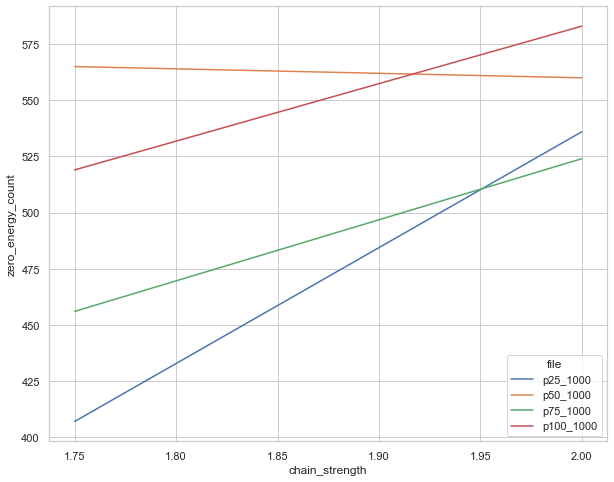

In [138]:
df_energy_0_counts = get_0_energy_counts_df(['p25_1000', 'p50_1000', 'p75_1000', 'p100_1000'], bottom=1.75, top=2.00)
sns.set(rc={'figure.figsize':(10,8)})
sns.set_style("whitegrid", {'axes.grid' : True})
sns.lineplot(data=df_energy_0_counts, x="chain_strength", y="zero_energy_count", hue="file")

In [141]:
for c in df.chain_strength.unique():
    print(c)

1.75
2.0


In [161]:
def get_percentage_ground_states(df, chain_strength):
    temp_df = df[df.chain_strength == chain_strength]
    total_samples = temp_df.shape[0]
    temp_df = temp_df[temp_df.energy == 0]
    return round(temp_df.shape[0]/total_samples,2)
    
def get_best_chain_strength(filename):
    df = pd.read_csv(f'./sat_ratio/outputs/{filename}.csv')
    df = df[df.type == 'raw']
    df = df[df.qpu == 'DW_2000Q_6']
    print(f"[{filename}]unique input values: {len(df.input_values.unique())}/{df.shape[0]}")
    max_percentage = None
    
    chain_strengths = df.chain_strength.unique()
    
    # find_max
    for cs in chain_strengths:
        percentage = get_percentage_ground_states(df, cs)
        if max_percentage == None:
            max_percentage = percentage
        else:
            max_percentage = max(max_percentage, percentage)
            
    best_chain_strengths = []
    
    for cs in chain_strengths:
        percentage = get_percentage_ground_states(df, cs)
        if percentage == max_percentage:
            best_chain_strengths.append(cs)
            
    return best_chain_strengths, max_percentage
    
    
def get_best_scores(filenames):
    best_scores = []
    count_samples = []
    names = []
    for filename in filenames:
        _, best_score = get_best_chain_strength(filename)
        best_scores.append(best_score)
        splitted_name = filename.split("_")
        names.append(splitted_name[0])
        if len(splitted_name) == 1:
            count_samples.append(100)
        else:
            count_samples.append(int(splitted_name[1]))
    return pd.DataFrame({
        'file': names,
        'num_samples': count_samples,
        'percentage_ground': best_scores
    })
    
        
        

In [162]:
df = get_best_scores(['p25', 'p50', 'p75', 'p100','p25_500', 'p50_500', 'p75_500', 'p100_500','p25_1000', 'p50_1000', 'p75_1000', 'p100_1000',])
df

[p25]unique input values: 1801/2000
[p50]unique input values: 1802/2000
[p75]unique input values: 1779/2000
[p100]unique input values: 1811/2000
[p25_500]unique input values: 2000/2000
[p50_500]unique input values: 2000/2000
[p75_500]unique input values: 2000/2000
[p100_500]unique input values: 2000/2000
[p25_1000]unique input values: 2000/2000
[p50_1000]unique input values: 2000/2000
[p75_1000]unique input values: 2000/2000
[p100_1000]unique input values: 2000/2000


,file,num_samples,percentage_ground
0,p25,100,0.48
1,p50,100,0.58
2,p75,100,0.48
3,p100,100,0.56
4,p25,500,0.63
5,p50,500,0.55
6,p75,500,0.58
7,p100,500,0.56
8,p25,1000,0.54
9,p50,1000,0.56


In [158]:
"p50500".split("_")

['p50500']

In [163]:
df[df.file == 'p25'].percentage_ground.mean()

0.5499999999999999

In [164]:
df[df.file == 'p50'].percentage_ground.mean()

0.5633333333333334

In [165]:
df[df.file == 'p75'].percentage_ground.mean()

0.5266666666666667

In [166]:
df[df.file == 'p100'].percentage_ground.mean()

0.5666666666666668

<AxesSubplot:xlabel='file', ylabel='percentage_ground'>

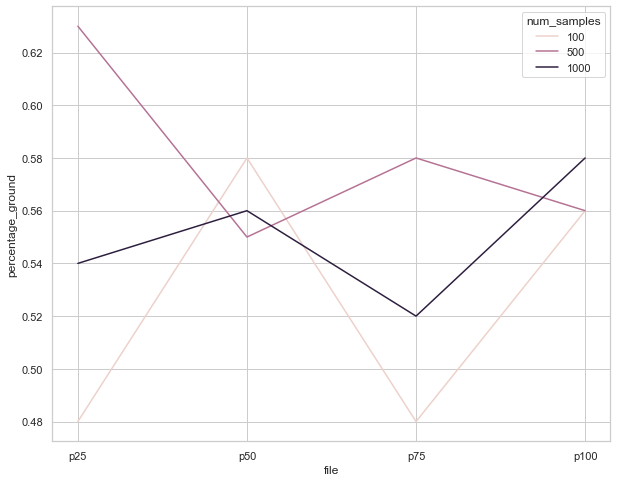

In [168]:
sns.set(rc={'figure.figsize':(10,8)})
sns.set_style("whitegrid", {'axes.grid' : True})

sns.lineplot(data=df, x="file", y="percentage_ground", hue="num_samples")

In [175]:
sample_sizes = []
diffs = []
names = []
for sample_size in [100, 500, 1000]:

    temp_df = df[df.num_samples == sample_size]
    max_percentage = temp_df.percentage_ground.max()
    min_percentage = temp_df.percentage_ground.min()
    diffs.append(max_percentage - min_percentage)
    sample_sizes.append(sample_size)
    names.append(file)
        
another_df = pd.DataFrame({
    'num_samples': sample_sizes,
    'diff': diffs
})
        
        
    

In [176]:
another_df

,num_samples,diff
0,100,0.10
1,500,0.08
2,1000,0.06


<AxesSubplot:xlabel='num_samples', ylabel='diff'>

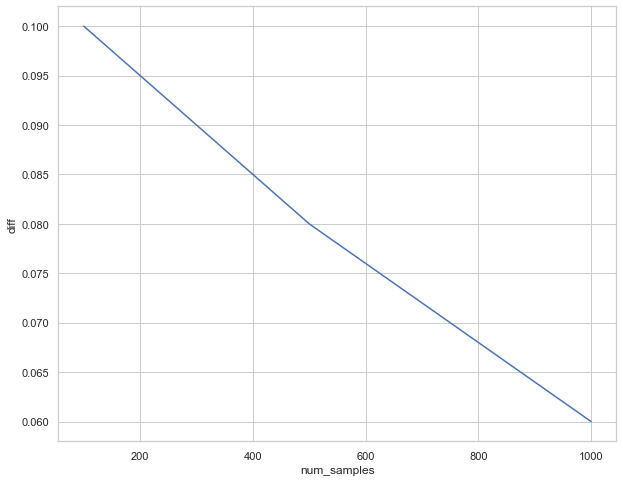

In [178]:
sns.set(rc={'figure.figsize':(10,8)})
sns.set_style("whitegrid", {'axes.grid' : True})

sns.lineplot(data=another_df, x="num_samples", y="diff")

# Finding Phase Transition

In [17]:
# input_ids = [[65,64,63,62,61,60,59,58,57,56,55,54,53,52,51,50,49,48,47,46,45,44,43,42,41,40,39,38,37,36,35,34,33,32,31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2]]
# df = get_results_dataframe('p10', input_ids, reads=100, bottom=1.25, top=2.25, is_pegasus=False, is_chimera=True, is_local_search=True)
# df
# df.to_csv('sat_ratio/outputs/p10.csv')
df
    

,file,type,chain_strength,energy,input_values,qpu
0,p10,raw,1.25,8.0,1264733710181464576,DW_2000Q_6
1,p10,raw,1.25,8.0,87835722140326400,DW_2000Q_6
2,p10,raw,1.25,10.0,52223484701686176,DW_2000Q_6
3,p10,raw,1.25,10.0,70136307125430720,DW_2000Q_6
4,p10,raw,1.25,10.0,700627215729277568,DW_2000Q_6
...,...,...,...,...,...,...
995,p10,pp_local_search,2.25,4.0,10990914887991035904,DW_2000Q_6
996,p10,pp_local_search,2.25,4.0,2010724038246327552,DW_2000Q_6
997,p10,pp_local_search,2.25,4.0,1696752401099251712,DW_2000Q_6
998,p10,pp_local_search,2.25,4.0,506221383709410752,DW_2000Q_6


In [18]:
input_ids = [[65,64,63,62,61,60,59,58,57,56,55,54,53,52,51,50,49,48,47,46,45,44,43,42,41,40,39,38,37,36,35,34,33,32,31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2]]
df = get_results_dataframe('p5', input_ids, reads=100, bottom=1.25, top=2.25, is_pegasus=False, is_chimera=True, is_local_search=True)
df
df.to_csv('sat_ratio/outputs/p5.csv')
df

file: p5
cnf vars, clauses, clauses_to_var = 191, 444, 2.32
qubo vars 253
conn avg, variance, max = 3.49, 2.23, 6
best embedding random_seed 2
best embedding max_chain_length 4
best embedding qubits used 396
best embedding variance: 0.6435472739820566
reads: 100
chimera: 1.25 raw 14.0
1.25 pp_local_search 14.0
************
reads: 100
chimera: 1.5 raw 0.0
1.5 pp_local_search 0.0
************
reads: 100
chimera: 1.75 raw 0.0
1.75 pp_local_search 0.0
************
reads: 100
chimera: 2.0 raw 0.0
2.0 pp_local_search 0.0
************
reads: 100
chimera: 2.25 raw 0.0
2.25 pp_local_search 0.0
************


,file,type,chain_strength,energy,input_values,qpu
0,p5,raw,1.25,14.0,343872040632962240,DW_2000Q_6
1,p5,raw,1.25,16.0,886132492871638144,DW_2000Q_6
2,p5,raw,1.25,16.0,353600520046693952,DW_2000Q_6
3,p5,raw,1.25,16.0,922217355877437056,DW_2000Q_6
4,p5,raw,1.25,16.0,309902612777200896,DW_2000Q_6
...,...,...,...,...,...,...
995,p5,pp_local_search,2.25,4.0,3124082999197770752,DW_2000Q_6
996,p5,pp_local_search,2.25,4.0,5012021290285949952,DW_2000Q_6
997,p5,pp_local_search,2.25,4.0,391259886755693888,DW_2000Q_6
998,p5,pp_local_search,2.25,4.0,3391112440319961600,DW_2000Q_6


In [19]:
input_ids = [[65,64,63,62,61,60,59,58,57,56,55,54,53,52,51,50,49,48,47,46,45,44,43,42,41,40,39,38,37,36,35,34,33,32,31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2]]
df = get_results_dataframe('p1p', input_ids, reads=100, bottom=1.25, top=2.25, is_pegasus=False, is_chimera=True, is_local_search=True)
df.to_csv('sat_ratio/outputs/p1p.csv')
df

file: p1p
cnf vars, clauses, clauses_to_var = 191, 444, 2.32
qubo vars 253
conn avg, variance, max = 3.49, 2.23, 6
best embedding random_seed 2
best embedding max_chain_length 4
best embedding qubits used 396
best embedding variance: 0.6435472739820566
reads: 100
chimera: 1.25 raw 6.0
1.25 pp_local_search 6.0
************
reads: 100
chimera: 1.5 raw 0.0
1.5 pp_local_search 0.0
************
reads: 100
chimera: 1.75 raw 0.0
1.75 pp_local_search 0.0
************
reads: 100
chimera: 2.0 raw 0.0
2.0 pp_local_search 0.0
************
reads: 100
chimera: 2.25 raw 0.0
2.25 pp_local_search 0.0
************


,file,type,chain_strength,energy,input_values,qpu
0,p1p,raw,1.25,6.0,147594231153336160,DW_2000Q_6
1,p1p,raw,1.25,10.0,184415221731864288,DW_2000Q_6
2,p1p,raw,1.25,10.0,147902012686765920,DW_2000Q_6
3,p1p,raw,1.25,12.0,256279855948140384,DW_2000Q_6
4,p1p,raw,1.25,12.0,112410945472446224,DW_2000Q_6
...,...,...,...,...,...,...
995,p1p,pp_local_search,2.25,4.0,2570901446526627840,DW_2000Q_6
996,p1p,pp_local_search,2.25,4.0,2528556744838939136,DW_2000Q_6
997,p1p,pp_local_search,2.25,4.0,156763887738556448,DW_2000Q_6
998,p1p,pp_local_search,2.25,4.0,4227720854592713728,DW_2000Q_6


In [20]:
input_ids = [[65,64,63,62,61,60,59,58,57,56,55,54,53,52,51,50,49,48,47,46,45,44,43,42,41,40,39,38,37,36,35,34,33,32,31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2]]
df = get_results_dataframe('p01', input_ids, reads=100, bottom=1.25, top=2.25, is_pegasus=False, is_chimera=True, is_local_search=True)
df.to_csv('sat_ratio/outputs/p01.csv')
df

file: p01
cnf vars, clauses, clauses_to_var = 191, 444, 2.32
qubo vars 253
conn avg, variance, max = 3.49, 2.23, 6
best embedding random_seed 2
best embedding max_chain_length 4
best embedding qubits used 396
best embedding variance: 0.6435472739820566
reads: 100
chimera: 1.25 raw 8.0
1.25 pp_local_search 8.0
************
reads: 100
chimera: 1.5 raw 2.0
1.5 pp_local_search 2.0
************
reads: 100
chimera: 1.75 raw 0.0
1.75 pp_local_search 0.0
************
reads: 100
chimera: 2.0 raw 0.0
2.0 pp_local_search 0.0
************
reads: 100
chimera: 2.25 raw 0.0
2.25 pp_local_search 0.0
************


,file,type,chain_strength,energy,input_values,qpu
0,p01,raw,1.25,8.0,9860656965003124,DW_2000Q_6
1,p01,raw,1.25,8.0,9210159073503028,DW_2000Q_6
2,p01,raw,1.25,8.0,13573545169659636,DW_2000Q_6
3,p01,raw,1.25,10.0,9514104916453168,DW_2000Q_6
4,p01,raw,1.25,10.0,19137820399478784,DW_2000Q_6
...,...,...,...,...,...,...
995,p01,pp_local_search,2.25,6.0,468215199470747776,DW_2000Q_6
996,p01,pp_local_search,2.25,6.0,606179613079728128,DW_2000Q_6
997,p01,pp_local_search,2.25,6.0,495318024609470016,DW_2000Q_6
998,p01,pp_local_search,2.25,6.0,8540477770280889344,DW_2000Q_6


In [27]:
input_ids = [[65,64,63,62,61,60,59,58,57,56,55,54,53,52,51,50,49,48,47,46,45,44,43,42,41,40,39,38,37,36,35,34,33,32,31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2]]
df = get_results_dataframe('p001', input_ids, reads=100, bottom=1.25, top=2.25, is_pegasus=False, is_chimera=True, is_local_search=True)
df.to_csv('sat_ratio/outputs/p001.csv')
df

file: p001
cnf vars, clauses, clauses_to_var = 191, 444, 2.32
qubo vars 253
conn avg, variance, max = 3.49, 2.23, 6
best embedding random_seed 2
best embedding max_chain_length 4
best embedding qubits used 396
best embedding variance: 0.6435472739820566
reads: 100
chimera: 1.25 raw 10.0
1.25 pp_local_search 10.0
************
reads: 100
chimera: 1.5 raw 2.0
1.5 pp_local_search 2.0
************
reads: 100
chimera: 1.75 raw 0.0
1.75 pp_local_search 0.0
************
reads: 100
chimera: 2.0 raw 2.0
2.0 pp_local_search 2.0
************
reads: 100
chimera: 2.25 raw 2.0
2.25 pp_local_search 2.0
************


,file,type,chain_strength,energy,input_values,qpu
0,p001,raw,1.25,10.0,147656430387003776,DW_2000Q_6
1,p001,raw,1.25,12.0,1943631074562236,DW_2000Q_6
2,p001,raw,1.25,12.0,1880722057408729,DW_2000Q_6
3,p001,raw,1.25,14.0,1896351441293514,DW_2000Q_6
4,p001,raw,1.25,14.0,10959557344121336,DW_2000Q_6
...,...,...,...,...,...,...
995,p001,pp_local_search,2.25,6.0,5194748276575000576,DW_2000Q_6
996,p001,pp_local_search,2.25,6.0,295040208806902464,DW_2000Q_6
997,p001,pp_local_search,2.25,6.0,2597315412959851520,DW_2000Q_6
998,p001,pp_local_search,2.25,6.0,5478529959363547136,DW_2000Q_6


In [29]:
input_ids = [[65,64,63,62,61,60,59,58,57,56,55,54,53,52,51,50,49,48,47,46,45,44,43,42,41,40,39,38,37,36,35,34,33,32,31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2]]
df = get_results_dataframe('p0001', input_ids, reads=100, bottom=1.25, top=2.25, is_pegasus=False, is_chimera=True, is_local_search=True)
df.to_csv('sat_ratio/outputs/p0001.csv')
df

file: p0001
cnf vars, clauses, clauses_to_var = 191, 444, 2.32
qubo vars 253
conn avg, variance, max = 3.49, 2.23, 6
best embedding random_seed 2
best embedding max_chain_length 4
best embedding qubits used 396
best embedding variance: 0.6435472739820566
reads: 100
chimera: 1.25 raw 10.0
1.25 pp_local_search 10.0
************
reads: 100
chimera: 1.5 raw 2.0
1.5 pp_local_search 2.0
************
reads: 100
chimera: 1.75 raw 2.0
1.75 pp_local_search 2.0
************
reads: 100
chimera: 2.0 raw 2.0
2.0 pp_local_search 2.0
************
reads: 100
chimera: 2.25 raw 2.0
2.25 pp_local_search 2.0
************


,file,type,chain_strength,energy,input_values,qpu
0,p0001,raw,1.25,10.0,1309268132305303,DW_2000Q_6
1,p0001,raw,1.25,14.0,184450294389079,DW_2000Q_6
2,p0001,raw,1.25,14.0,36176980592990672,DW_2000Q_6
3,p0001,raw,1.25,14.0,396517173291782784,DW_2000Q_6
4,p0001,raw,1.25,16.0,429366473662280,DW_2000Q_6
...,...,...,...,...,...,...
995,p0001,pp_local_search,2.25,4.0,9741478647803215872,DW_2000Q_6
996,p0001,pp_local_search,2.25,4.0,3504863740984280064,DW_2000Q_6
997,p0001,pp_local_search,2.25,4.0,2405631685543209472,DW_2000Q_6
998,p0001,pp_local_search,2.25,6.0,2247867371081982208,DW_2000Q_6


In [31]:
input_ids = [[65,64,63,62,61,60,59,58,57,56,55,54,53,52,51,50,49,48,47,46,45,44,43,42,41,40,39,38,37,36,35,34,33,32,31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2]]
df = get_results_dataframe('p0001', input_ids, reads=500, bottom=1.25, top=2.25, is_pegasus=False, is_chimera=True, is_local_search=True)
df.to_csv('sat_ratio/outputs/p0001_500.csv')
df

file: p0001
cnf vars, clauses, clauses_to_var = 191, 444, 2.32
qubo vars 253
conn avg, variance, max = 3.49, 2.23, 6
best embedding random_seed 2
best embedding max_chain_length 4
best embedding qubits used 396
best embedding variance: 0.6435472739820566
reads: 500
chimera: 1.25 raw 10.0
1.25 pp_local_search 10.0
************
reads: 500
chimera: 1.5 raw 2.0
1.5 pp_local_search 2.0
************
reads: 500
chimera: 1.75 raw 0.0
1.75 pp_local_search 0.0
************
reads: 500
chimera: 2.0 raw 0.0
2.0 pp_local_search 0.0
************
reads: 500
chimera: 2.25 raw 2.0
2.25 pp_local_search 2.0
************


,file,type,chain_strength,energy,input_values,qpu
0,p0001,raw,1.25,10.0,72260904590408256,DW_2000Q_6
1,p0001,raw,1.25,10.0,72834128135281488,DW_2000Q_6
2,p0001,raw,1.25,12.0,1590172670167700,DW_2000Q_6
3,p0001,raw,1.25,12.0,288660112000897728,DW_2000Q_6
4,p0001,raw,1.25,12.0,253470693807036832,DW_2000Q_6
...,...,...,...,...,...,...
4995,p0001,pp_local_search,2.25,6.0,1316669840441866,DW_2000Q_6
4996,p0001,pp_local_search,2.25,6.0,2115763769662621,DW_2000Q_6
4997,p0001,pp_local_search,2.25,6.0,10160309459254501376,DW_2000Q_6
4998,p0001,pp_local_search,2.25,6.0,294201126797130816,DW_2000Q_6


In [32]:
input_ids = [[65,64,63,62,61,60,59,58,57,56,55,54,53,52,51,50,49,48,47,46,45,44,43,42,41,40,39,38,37,36,35,34,33,32,31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2]]
df = get_results_dataframe('p00001', input_ids, reads=500, bottom=1.25, top=2.25, is_pegasus=False, is_chimera=True, is_local_search=True)
df.to_csv('sat_ratio/outputs/p00001_500.csv')
df

file: p00001
cnf vars, clauses, clauses_to_var = 191, 444, 2.32
qubo vars 253
conn avg, variance, max = 3.49, 2.23, 6
best embedding random_seed 2
best embedding max_chain_length 4
best embedding qubits used 396
best embedding variance: 0.6435472739820566
reads: 500
chimera: 1.25 raw 8.0
1.25 pp_local_search 8.0
************
reads: 500
chimera: 1.5 raw 0.0
1.5 pp_local_search 0.0
************
reads: 500
chimera: 1.75 raw 2.0
1.75 pp_local_search 2.0
************
reads: 500
chimera: 2.0 raw 2.0
2.0 pp_local_search 2.0
************
reads: 500
chimera: 2.25 raw 2.0
2.25 pp_local_search 2.0
************


,file,type,chain_strength,energy,input_values,qpu
0,p00001,raw,1.25,8.0,145102308229805504,DW_2000Q_6
1,p00001,raw,1.25,8.0,1874404985314783,DW_2000Q_6
2,p00001,raw,1.25,8.0,37612380777125312,DW_2000Q_6
3,p00001,raw,1.25,8.0,288468854120691072,DW_2000Q_6
4,p00001,raw,1.25,10.0,1218559551977266,DW_2000Q_6
...,...,...,...,...,...,...
4995,p00001,pp_local_search,2.25,6.0,901942133187737216,DW_2000Q_6
4996,p00001,pp_local_search,2.25,6.0,953686450433922688,DW_2000Q_6
4997,p00001,pp_local_search,2.25,8.0,3826958571840142336,DW_2000Q_6
4998,p00001,pp_local_search,2.25,8.0,1530051206660006144,DW_2000Q_6


In [42]:
input_ids = [[65,64,63,62,61,60,59,58,57,56,55,54,53,52,51,50,49,48,47,46,45,44,43,42,41,40,39,38,37,36,35,34,33,32,31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2]]
df = get_results_dataframe('p000001', input_ids, reads=3000, bottom=1.25, top=2.25, is_pegasus=False, is_chimera=True, is_local_search=True, random_seed_chimera=2)
df.to_csv('sat_ratio/outputs/p000001_3000.csv')
df

file: p000001
cnf vars, clauses, clauses_to_var = 191, 444, 2.32
qubo vars 253
conn avg, variance, max = 3.49, 2.23, 6
reads: 3000
chimera: 1.25 raw 6.0
1.25 pp_local_search 6.0
************
reads: 3000
chimera: 1.5 raw 2.0
1.5 pp_local_search 2.0
************
reads: 3000
chimera: 1.75 raw 0.0
1.75 pp_local_search 0.0
************
reads: 3000
chimera: 2.0 raw 2.0
2.0 pp_local_search 2.0
************
reads: 3000
chimera: 2.25 raw 2.0
2.25 pp_local_search 2.0
************


,file,type,chain_strength,energy,input_values,qpu
0,p000001,raw,1.25,6.0,36987220554984336,DW_2000Q_6
1,p000001,raw,1.25,6.0,334454923573909,DW_2000Q_6
2,p000001,raw,1.25,6.0,217334619593861664,DW_2000Q_6
3,p000001,raw,1.25,6.0,461719084737172,DW_2000Q_6
4,p000001,raw,1.25,8.0,289198699530792896,DW_2000Q_6
...,...,...,...,...,...,...
29995,p000001,pp_local_search,2.25,8.0,2202386740442936064,DW_2000Q_6
29996,p000001,pp_local_search,2.25,8.0,584398032272866176,DW_2000Q_6
29997,p000001,pp_local_search,2.25,8.0,9163806249801592832,DW_2000Q_6
29998,p000001,pp_local_search,2.25,8.0,581747758667833856,DW_2000Q_6


In [7]:
from pysat.solvers import Minisat22
from pysat.formula import CNF
from os import walk

In [8]:
from os import listdir
from os.path import isfile, join
cnf_files = [f for f in listdir("/Users/stefaniemuroyalei/Documents/satv2/unicorn/sat_ratio") if isfile(join("/Users/stefaniemuroyalei/Documents/satv2/unicorn/sat_ratio", f)) and "cnf" in f]

In [12]:
cnf_files = [f for f in cnf_files if f!="1.cnf" and f!="p1.cnf" and f!= "8bit_p1.cnf" and f!= "8bit_p01.cnf"]

In [13]:
cnf_files

['p25.cnf',
 'p00001.cnf',
 'p000001.cnf',
 'p5.cnf',
 'p50.cnf',
 'p75.cnf',
 'p100.cnf',
 'p0001.cnf',
 'p01.cnf',
 'p001.cnf',
 'p10.cnf',
 'p1p.cnf']

In [18]:
file_names_to_probs = {
    'p100.cnf': 1,
    'p75.cnf': 0.75,
    'p50.cnf': 0.50,
    'p25.cnf': 0.25,
    'p10.cnf': 0.10,
    'p5.cnf': 0.5,
    'p1p.cnf':0.01,
    'p01.cnf':0.001,
    'p001.cnf': 0.0001,
    'p0001.cnf': 0.00001,
    'p00001.cnf': 0.000001,
    'p000001.cnf': 0.0000001
}
assert(len(file_names_to_probs.keys()) == len(cnf_files))

In [19]:
from pysat.solvers import Solver
import time
solvers = ['cadical', 'gluecard3', 'gluecard4','glucose3', 'glucose4', 'lingeling', 'maplechrono',
        'maplecm', 'maplesat', 'mergesat3', 'minicard', 'minisat22','minisat-gh']
times_column = []
probs_column = []
solvers_column = []
for file in cnf_files:
    print(f"processing file: {file}")
    formula = CNF(from_file=f'./sat_ratio/{file}')
    assert(file in file_names_to_probs.keys())
    for solver_name in solvers:
        solver = Solver(name=solver_name, bootstrap_with=formula.clauses)
        current_times = []
        for i in range(100000):
            init_time = time.perf_counter()
            solver.solve()
            current_times.append(round((time.perf_counter() - init_time)*10000, 3))
            
        avg_time = sum(current_times)/len(current_times)
        #times.append(sum(current_times)/len(current_times))
        probs_column.append(file_names_to_probs[file])
        times_column.append(avg_time)
        solvers_column.append(solver_name)
cnf_files_df = pd.DataFrame({
    'sat_ratio': probs_column,
    'solver': solvers_column,
    'time': times_column
})
cnf_files_df.sort_values(by=['time'])

processing file: p25.cnf
processing file: p00001.cnf
processing file: p000001.cnf
processing file: p5.cnf
processing file: p50.cnf
processing file: p75.cnf
processing file: p100.cnf
processing file: p0001.cnf
processing file: p01.cnf
processing file: p001.cnf
processing file: p10.cnf
processing file: p1p.cnf


,sat_ratio,solver,time
34,1.000000e-07,maplesat,0.041724
36,1.000000e-07,minicard,0.041970
37,1.000000e-07,minisat22,0.041983
38,1.000000e-07,minisat-gh,0.042075
26,1.000000e-07,cadical,0.042365
...,...,...,...
70,7.500000e-01,lingeling,0.391378
7,2.500000e-01,maplecm,0.456831
72,7.500000e-01,maplecm,0.462590
59,5.000000e-01,maplecm,0.467231


In [20]:
from os.path import exists

In [21]:
import math
max_counts = []
probs = []
for file in cnf_files:
    file_temp = file.split(".")[0]
    sat_ratio = file_names_to_probs[file]
    probs.append(file_names_to_probs[file])
    if exists(f'./sat_ratio/outputs/{file_temp}.csv'):
        df = pd.read_csv(f'./sat_ratio/outputs/{file_temp}.csv')
        df = df[df.type=="raw"]
        max_count_gs = df[df.energy==0].groupby(['chain_strength']).size().max()
        if not math.isnan(max_count_gs):
            max_counts.append(max_count_gs)
        else:
            max_counts.append(0)
    else:
        max_counts.append(0)
df_gs = pd.DataFrame({
    'sat_ratio': probs,
    'ground_states': max_counts
})

In [22]:
df_gs

,sat_ratio,ground_states
0,2.500000e-01,48
1,1.000000e-06,0
2,1.000000e-07,0
3,5.000000e-01,53
4,5.000000e-01,58
5,7.500000e-01,48
6,1.000000e+00,56
7,1.000000e-05,0
8,1.000000e-03,23
9,1.000000e-04,7


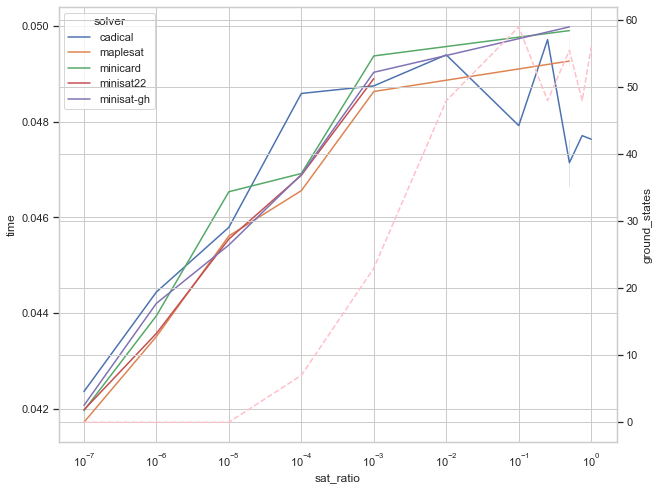

In [25]:
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(10,8)})
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots()

a = sns.lineplot(x='sat_ratio', y='time', data=cnf_files_df[cnf_files_df.time < 0.05], hue="solver", ax=ax)

ax2 = ax.twinx()


a = sns.lineplot(x='sat_ratio', y='ground_states', color="pink",  data=df_gs, ax=ax2)
a.set(xscale="log")
ax2.lines[0].set_linestyle("--")

# 8 bit Experiments

In [8]:
input_ids = [[9,8,7,6,5,4,3,2]]
df = get_results_dataframe('/8bit_p1', input_ids, reads=100, bottom=1.5, top=2.25, is_pegasus=False, is_chimera=True, is_local_search=True)
df.to_csv('sat_ratio/outputs/8bit_p1.csv')
df

file: /8bit_p1
cnf vars, clauses, clauses_to_var = 23, 52, 2.26
qubo vars 29
conn avg, variance, max = 3.38, 2.03, 6
best embedding random_seed 80
best embedding max_chain_length 2
best embedding qubits used 42
best embedding variance: 0.2561576354679803
reads: 100
chimera: 1.5 raw 0.0
1.5 pp_local_search 0.0
************
reads: 100
chimera: 1.75 raw 0.0
1.75 pp_local_search 0.0
************
reads: 100
chimera: 2.0 raw 0.0
2.0 pp_local_search 0.0
************
reads: 100
chimera: 2.25 raw 0.0
2.25 pp_local_search 0.0
************


,file,type,chain_strength,energy,input_values,qpu
0,/8bit_p1,raw,1.50,0.0,2,DW_2000Q_6
1,/8bit_p1,raw,1.50,0.0,1,DW_2000Q_6
2,/8bit_p1,raw,1.50,0.0,0,DW_2000Q_6
3,/8bit_p1,raw,1.50,0.0,0,DW_2000Q_6
4,/8bit_p1,raw,1.50,0.0,2,DW_2000Q_6
...,...,...,...,...,...,...
795,/8bit_p1,pp_local_search,2.25,2.0,4,DW_2000Q_6
796,/8bit_p1,pp_local_search,2.25,2.0,69,DW_2000Q_6
797,/8bit_p1,pp_local_search,2.25,2.0,99,DW_2000Q_6
798,/8bit_p1,pp_local_search,2.25,2.0,68,DW_2000Q_6


<AxesSubplot:xlabel='energy', ylabel='Count'>

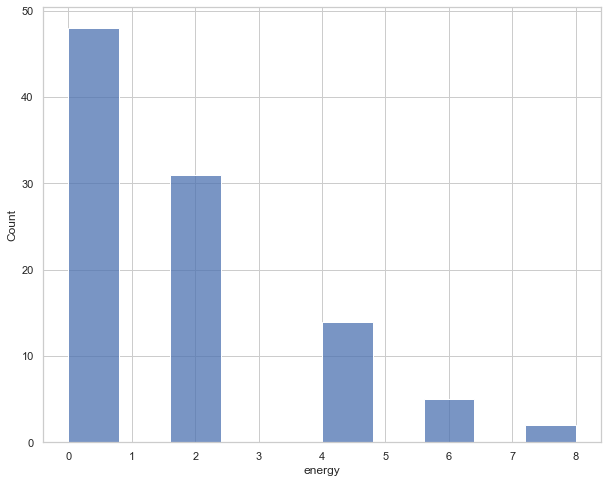

In [11]:
another_df = pd.read_csv('sat_ratio/outputs/p1p.csv')
sns.set(rc={'figure.figsize':(10,8)})
sns.set_style("whitegrid", {'axes.grid' : True})

sns.histplot(another_df[(another_df.type=="raw") & (another_df.chain_strength == 2)].energy)

<AxesSubplot:xlabel='energy', ylabel='Count'>

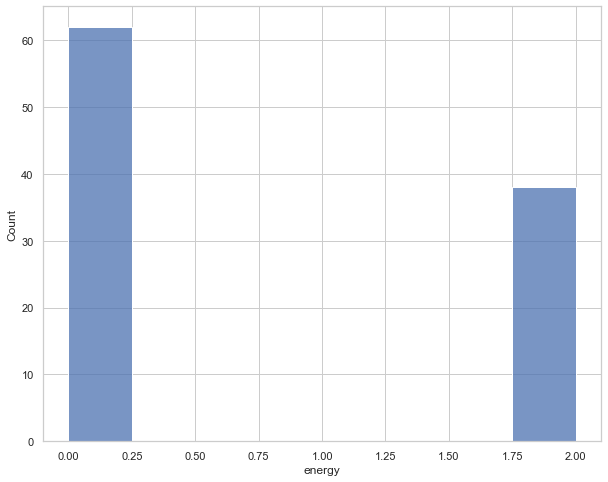

In [12]:
sns.histplot(df[(df.type=="raw") & (df.chain_strength == 2)].energy)

In [13]:
input_ids = [[9,8,7,6,5,4,3,2]]
df = get_results_dataframe('/8bit_p01', input_ids, reads=100, bottom=1.5, top=2.25, is_pegasus=False, is_chimera=True, is_local_search=True)
df.to_csv('sat_ratio/outputs/8bit_p01.csv')
df

file: /8bit_p01
cnf vars, clauses, clauses_to_var = 23, 52, 2.26
qubo vars 29
conn avg, variance, max = 3.38, 2.03, 6
best embedding random_seed 80
best embedding max_chain_length 2
best embedding qubits used 42
best embedding variance: 0.2561576354679803
reads: 100
chimera: 1.5 raw 0.0
1.5 pp_local_search 0.0
************
reads: 100
chimera: 1.75 raw 0.0
1.75 pp_local_search 0.0
************
reads: 100
chimera: 2.0 raw 0.0
2.0 pp_local_search 0.0
************
reads: 100
chimera: 2.25 raw 0.0
2.25 pp_local_search 0.0
************


,file,type,chain_strength,energy,input_values,qpu
0,/8bit_p01,raw,1.50,0.0,0,DW_2000Q_6
1,/8bit_p01,raw,1.50,0.0,0,DW_2000Q_6
2,/8bit_p01,raw,1.50,0.0,0,DW_2000Q_6
3,/8bit_p01,raw,1.50,0.0,0,DW_2000Q_6
4,/8bit_p01,raw,1.50,0.0,0,DW_2000Q_6
...,...,...,...,...,...,...
795,/8bit_p01,pp_local_search,2.25,2.0,4,DW_2000Q_6
796,/8bit_p01,pp_local_search,2.25,2.0,18,DW_2000Q_6
797,/8bit_p01,pp_local_search,2.25,2.0,62,DW_2000Q_6
798,/8bit_p01,pp_local_search,2.25,2.0,7,DW_2000Q_6


<AxesSubplot:xlabel='energy', ylabel='Count'>

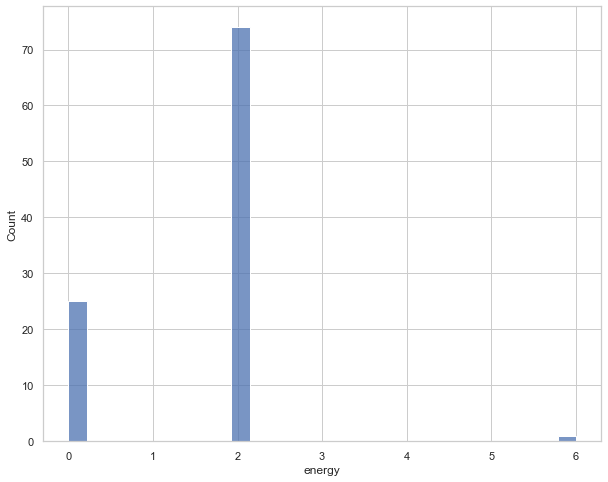

In [16]:
another_df = pd.read_csv('sat_ratio/outputs/8bit_p01.csv')
sns.set(rc={'figure.figsize':(10,8)})
sns.set_style("whitegrid", {'axes.grid' : True})

sns.histplot(another_df[(another_df.type=="raw") & (another_df.chain_strength == 2)].energy)

<AxesSubplot:xlabel='energy', ylabel='Count'>

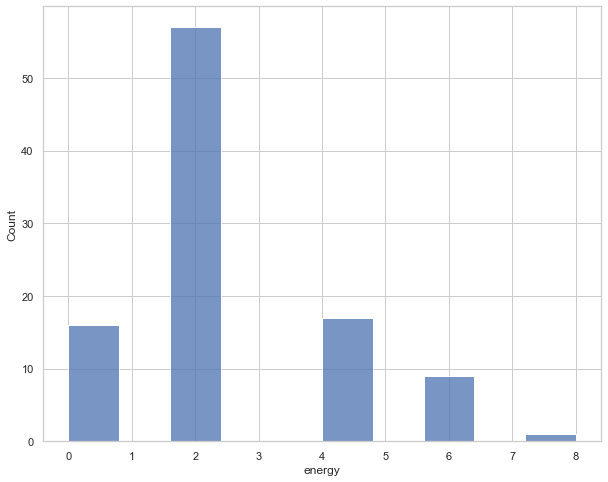

In [15]:
another_df = pd.read_csv('sat_ratio/outputs/p01.csv')
sns.histplot(another_df[(another_df.type=="raw") & (another_df.chain_strength == 2)].energy)